In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

In [2]:
class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]
    
def heuristic(a, b):    
    (x1, y1) = a
    (x2, y2) = b   
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def a_star_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

In [28]:
class Graph:
    def __init__(self):
        self.edges = {}
        
            
    def __init__(self,image,heightmap=None):
        def get_neighbors(point,img):
            part = img[point[0]-1:point[0]+2, point[1]-1:point[1]+2].copy()
            part[1,1] = 0
            part_neighbors = np.argwhere(part) - 1
            part_neighbors 
            return [tuple(aa) for aa in (point + part_neighbors)]
        
        self.edges = {}
        
        image = image.T
        
        if heightmap is None:
            self.heights = None
        else:
            self.heights = {}
            heightmap = heightmap.T
            
        for point in np.argwhere(image):
            self.edges[(point[0],point[1])] = get_neighbors(point,image)   
            if(self.heights is not None):
                self.heights[(point[0],point[1])]= heightmap[point[0],point[1]]    
        
        self.calc_costs()
    
    def calc_costs(self):
        self.costs = {}
        for key in self.edges:
            for neighbor in self.edges[key]:
                self.costs[(key,neighbor)] = self.euclidean_distance(key,neighbor)       
    
    def neighbors(self, id):
        return self.edges[id]
    
    def cost(self, a,b):
        return self.costs[(a,b)]
    
    def get_nearest_edge(self,a):
        points = np.array(list(self.edges.keys()))
        distance = ((points - np.array(a))**2).sum(axis=1)
        return tuple(points[np.argmin(distance)])
        
    
    def plot(self,*args,**kwargs):
        points = np.array(list(self.edges.keys()))
        return plt.scatter(points[:,0],points[:,1],*args,**kwargs)
    
    def euclidean_distance(self, a,b):
        (x1, y1) = a
        (x2, y2) = b
        if(self.heights is not None):
            z1,z2 = self.heights[(x1,y1)],self.heights[(x2,y2)]
        else:
            z1,z2=0,0
        return ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)**0.5
    
    def find_path(self,point1,point2):
        point1 = self.get_nearest_edge(point1)
        point2 = self.get_nearest_edge(point2)
        
        cf, costs = a_star_search(self,point1,point2)
        
        curpoint = point2
        endpoint = point1
        path = [curpoint]
        while(curpoint != endpoint):
            neighbours = self.neighbors(curpoint)
            curpoint = neighbours[np.argmin([costs[point] if point in costs else np.inf for point in neighbours])]
            path.append(curpoint)
        path = path[::-1]
        
        return path
        

In [62]:
# Graph()
path = '..\\map\\raw_data\\Camp_Jackal_Main_No_Text_High_Res_Roads_Skeleton.png'
roads_img = plt.imread(path)
roads_img = (roads_img[:,:,0] == 0).astype(np.int8)

In [102]:
roads_graph = Graph(roads_img)

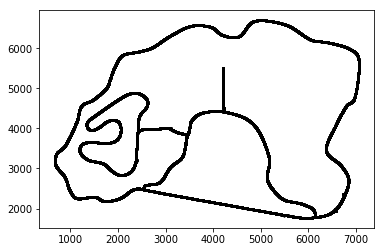

In [39]:
roads_graph.plot(c="black",s=2)
plt.show()

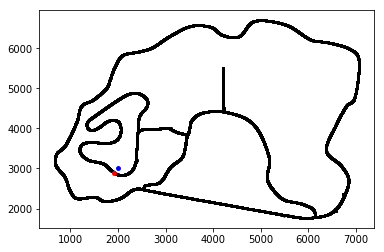

In [59]:
point = (2000,3000)
nearest_point = roads_graph.get_nearest_edge(point)
roads_graph.plot(c="black",s=2)
plt.scatter(point[0],point[1],c='b',s=15)
plt.scatter(nearest_point[0],nearest_point[1],c='r',s=15)
plt.show()

In [87]:
point1 = roads_graph.get_nearest_edge((2000,3000))
point2 = roads_graph.get_nearest_edge((4000,6000))

cf, costs = a_star_search(roads_graph,point1,point2)

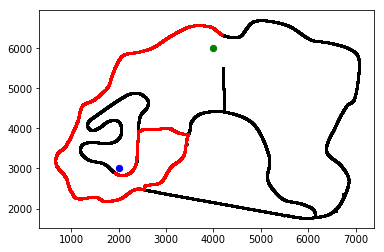

In [103]:
point1 = (2000,3000)
point2 = (4000,6000)

path = np.array(roads_graph.find_path(point1,point2))

roads_graph.plot(c="black",s=2)
plt.scatter(path[:,0],path[:,1],c='r',s=2)
plt.scatter(point1[0],point1[1],c='b',s=40)
plt.scatter(point2[0],point2[1],c='g',s=40)
plt.show()

In [106]:
%%timeit
roads_graph.find_path(point1,point2)

450 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
import matplotlib.pyplot as plt

class path_finder(Graph):
    
    _map_files  = {'camp_jackal' : '..\\map\\raw_data\\Camp_Jackal_Main_No_Text_High_Res_Roads_Skeleton.png',
                   'miramar': '..\\map\\raw_data\\Miramar_Main_No_Text_High_Res_Roads_Skeleton.png'}
    
    _map_size_meters = {'camp_jackal' : 2000,
                        'miramar'     : 8000}
    

    def __init__(self,map_name):
        assert map_name in self._map_files, f'unknown map: {map_name}'
        
        self.map_name = map_name
        path = self._map_files[map_name]
        roads_img = plt.imread(path)
        roads_img = (roads_img[:,:,0] == 0).astype(np.int8)
        
        Graph.__init__(self,roads_img)
        
        self._graph_scale = self._map_size_meters[map_name]/roads_img.shape[0]
        
        
    def find_path(self,point1,point2):
        
        point1 = np.array(point1)/self._graph_scale
        point2 = np.array(point2)/self._graph_scale
        
        point1  = self.get_nearest_edge(point1)
        point2  = self.get_nearest_edge(point2)
        
        path = Graph.find_path(self,point1,point2)
        
        path = np.array(path)*self._graph_scale
        
        return path
        

In [30]:
pf = path_finder('camp_jackal')

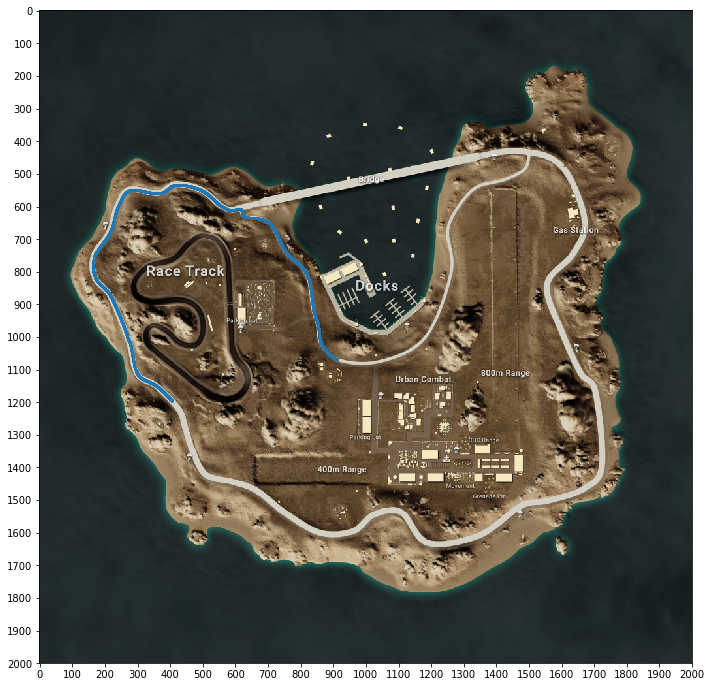

In [34]:
map_image = plt.imread('../map/low_res/Camp_Jackal_Main_Low_Res.png')

point1 = 900,1100
point2 = 400,1200

path = pf.find_path(point1,point2)*0.5


plt.figure(figsize=(12,12))
plt.xticks(np.arange(0, 1001, step=50),np.arange(0, 1001, step=50)*2)
plt.yticks(np.arange(0, 1001, step=50),np.arange(0, 1001, step=50)*2)

plt.scatter(path[:,0],path[:,1],s=2)
plt.imshow(map_image)
plt.show()

In [1]:
from map_navigation import path_finder
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pf = path_finder('camp_jackal')

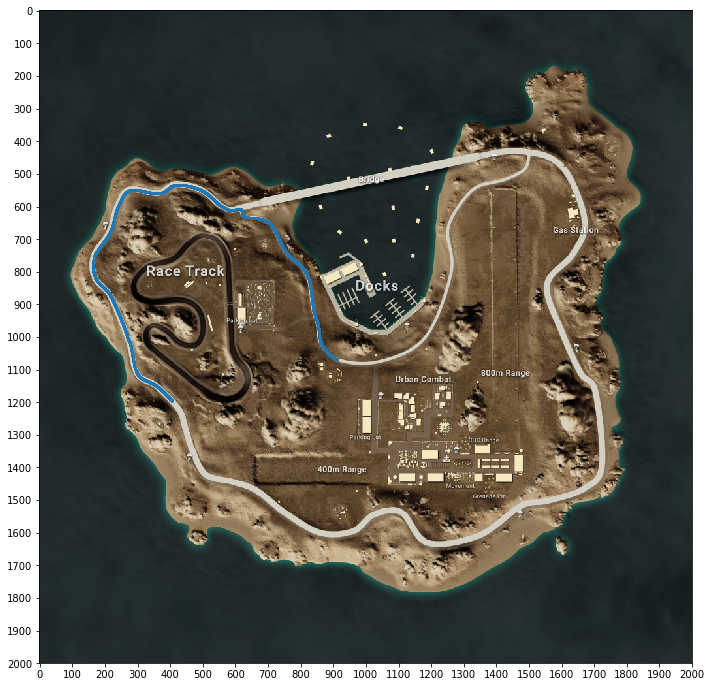

In [3]:
map_image = plt.imread('../map/low_res/Camp_Jackal_Main_Low_Res.png')

point1 = 900,1100
point2 = 400,1200

path = pf.find_path(point1,point2)*0.5


plt.figure(figsize=(12,12))
plt.xticks(np.arange(0, 1001, step=50),np.arange(0, 1001, step=50)*2)
plt.yticks(np.arange(0, 1001, step=50),np.arange(0, 1001, step=50)*2)

plt.scatter(path[:,0],path[:,1],s=2)
plt.imshow(map_image)
plt.show()